In [0]:
##good summary of pywake capabilities here: https://www.nrel.gov/wind/assets/pdfs/engineering-wkshp2022-4-2-valottarodrigues.pdf

In [0]:
###limitations of this analysis due to time:
#1. was not able to get pywake to take air density time series so I'm not utilizing the temp, dewpoint, and pressure vars
#2. no sub gridscale orographic data
#3. no wind turning, no speedup
#4. only modeling GE 1.7-103s even though the last ten or so turbines are 1.7-100s
#5. was not able to get pywake to take a time series wind shear exponent, though its possible this is only needed for interpolating the wind speed to our hub height of 80m?

In [0]:
#libs etc
!pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.12.1 requires pyspark>=2.1.0, which is not installed.
databricks-feature-store 0.14.3 requires pyspark<4,>=3.1.2, which is not installed.
mlflow 2.11.1 requires packaging<24, but you have packaging 24.2 which is incompatible.
ydata-profiling 4.2.0 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.4 which is incompatible.
ydata-profiling 4.2.0 requires pandas!=1.4.0,<2,>1.1, but you have pandas 2.2.3 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.4 which is incompatible.
mlflow-skinny 2.5.0 requires packaging<24, but you have packaging 24.2 which is incompatible.
mleap 0.20.0 requires scikit-learn<0.23.0,>=0.22.0, but you have scikit-learn 1.1.1 which is incompatible.

[notice] A new release of pip available: 22.2.2 -> 25.0
[notice] To update, run: pip instal

In [0]:
#certain chunks of py_wake are picky about scipy version, some package misalignment here
%pip install --upgrade scipy==1.10 -q
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
databricks-feature-store 0.14.3 requires pyspark<4,>=3.1.2, which is not installed.
mlflow 2.11.1 requires packaging<24, but you have packaging 24.2 which is incompatible.
ydata-profiling 4.2.0 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.4 which is incompatible.
ydata-profiling 4.2.0 requires pandas!=1.4.0,<2,>1.1, but you have pandas 2.2.3 which is incompatible.
mleap 0.20.0 requires scikit-learn<0.23.0,>=0.22.0, but you have scikit-learn 1.1.1 which is incompatible.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
#imports, py_wake is heavy so we just take the bits we need
import pandas as pd
from py_wake import WindFarmModel
from py_wake.wind_turbines import WindTurbine, WindTurbines
from tqdm.notebook import tqdm
from py_wake.utils import layouts
from py_wake.utils.profiling import timeit, profileit
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80
from py_wake.literature.gaussian_models import Zong_PorteAgel_2020
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.site.shear import PowerShear
#could not get an all2all model with blockage to work
#from py_wake.literature.gaussian_models import Ott_Nielsen_2014_Blockage
from py_wake.utils.plotting import setup_plot
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake.site import XRSite
from py_wake.site import UniformWeibullSite
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import stats
#import py_wake

In [0]:
#grab the supplied data for the turbines and time series weather
generation_weather_df = pd.read_csv("/dbfs/FileStore/tmp/generation_data.csv", index_col=0)
turbine_locs = pd.read_csv("/dbfs/FileStore/tmp/AnonymizedTurbines.csv").sort_values(by=['x', 'y'])

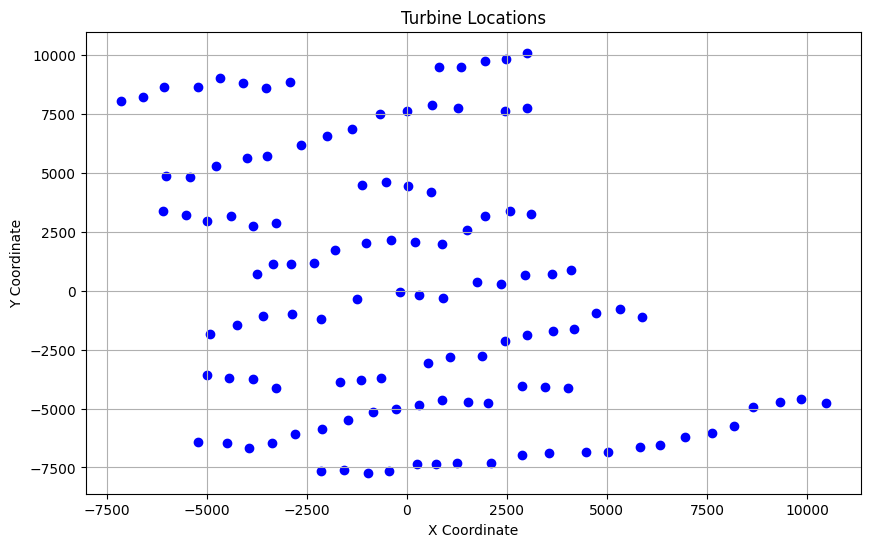

In [0]:
#first look @ the turbine distribution
#those look like ridgelines which means our lack of subgrid orography might hurt our estimation
plt.figure(figsize=(10, 6))
plt.scatter(turbine_locs['x'], turbine_locs['y'], c='blue', marker='o')
plt.title('Turbine Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [0]:
display(generation_weather_df.reset_index().head(10))

index,generation_mw,temp_2m,dew_2m,mslp,wind_10m_mps,wind_10m_dir,wind_100m_mps,wind_100m_dir,custom_height,wind_80m_mps,wind_80m_dir,ghi,wind_alpha
2023-01-01 07:00:00+00:00,68.6064803756134,3.68,-4.03,1007,3.97,38,10.58,43,80,9.62,43,0.0,0.4256951609360519
2023-01-01 08:00:00+00:00,117.56081520066,2.29,-5.61,1007,4.12,43,9.73,47,80,8.95,47,0.0,0.3732156242352173
2023-01-01 09:00:00+00:00,106.10359110148956,0.08,-7.18,1008,4.09,44,8.54,49,80,7.95,48,0.0,0.3197345626816633
2023-01-01 10:00:00+00:00,87.23409209354531,-1.34,-6.55,1008,3.34,5,7.04,22,80,6.55,20,0.0,0.3238261923305477
2023-01-01 11:00:00+00:00,49.02822940078574,-1.97,-6.62,1009,3.54,348,6.92,15,80,6.48,12,0.0,0.29110283243097
2023-01-01 12:00:00+00:00,27.02396596724417,-0.82,-5.49,1009,3.76,349,6.96,13,80,6.56,10,0.0,0.2674213946829011
2023-01-01 13:00:00+00:00,20.58623543399338,-0.2,-4.54,1009,3.36,352,6.14,19,80,5.79,15,0.0,0.2618290937513236
2023-01-01 14:00:00+00:00,11.26413215981543,-0.6,-4.21,1010,2.53,334,4.53,29,80,4.28,22,0.0,0.252977680837014
2023-01-01 15:00:00+00:00,11.38662900942823,0.43,-3.23,1011,1.59,316,3.37,41,80,3.13,33,20.0,0.3262327765508871
2023-01-01 16:00:00+00:00,14.3024270284508,0.01,-2.98,1012,2.12,32,4.37,58,80,4.07,55,141.0,0.3141455760416704


In [0]:
###load the power curve parsed from windatlas.xyz
###wind-turbine-models is my preferred source for this data but does not have a power curve for the 1.7-103
###windatlas power curve has a cutout at 20m/s. Shifting upwards to 23m/s to match wind-turbine-models source
df_ge17_103_curve_pd = pd.read_csv("/dbfs/FileStore/tmp/ge17_103_curve.csv")
fig = px.line(df_ge17_103_curve_pd, x='wind_speed_m_s', y='output_watts', title='Wind Speed vs Output Watts')
fig.show()

In [0]:
##1.7-103 is an older turbine model, I'm not able to find thrust and power coefficient curves for it
##substituting cp/ct curves from a GE model with a similar rotor diameter but slightly more output, the GE 2.5-103, as an approximation for the exercise
#its possible this is a source of error in the results
#ct should not be zero below the cutoff but it doesnt matter to the sim.
df_ge25_103_curve_pd = pd.read_csv("/dbfs/FileStore/tmp/ge275_103_curves.csv")
fig = px.line(df_ge25_103_curve_pd, x='wind_speed_m_s', y=['cp', 'ct'], title='Wind Speed vs Cp and Ct')
fig.show()

In [0]:
##I'm going to define a custom wind turbine in pywake using the data above
##I realize the last 9 turbines on the list are 1.7-100s but I'm just going to model the farm as all 1.7-103s due to time constraints

u = df_ge17_103_curve_pd.wind_speed_m_s.values
ct = df_ge25_103_curve_pd.ct.values
power = df_ge17_103_curve_pd.output_watts.values

my_wt = WindTurbine(name='GE_17_103_ctmod',
                    diameter=103,
                    hub_height=80,
                    powerCtFunction=PowerCtTabular(u,power,'W',ct))

In [0]:
coordinate_pairs = turbine_locs[['x', 'y']].values

                A         k  n_samples         f
0-30     7.804938  2.377697      968.0  0.078071
30-60    6.433548  2.351092      595.0  0.047988
60-90    6.033080  2.251658      494.0  0.039842
90-120   6.181691  2.265155      556.0  0.044842
120-150  7.619502  2.444543      883.0  0.071215
150-180  9.051992  2.401169     1517.0  0.122349
180-210  9.436878  2.775503     1736.0  0.140011
210-240  8.562632  2.463046     1197.0  0.096540
240-270  7.322204  2.216685      848.0  0.068393
270-300  7.148610  2.233240      719.0  0.057989
300-330  8.707273  2.244066     1223.0  0.098637
330-360  9.840981  2.176360     1647.0  0.132833


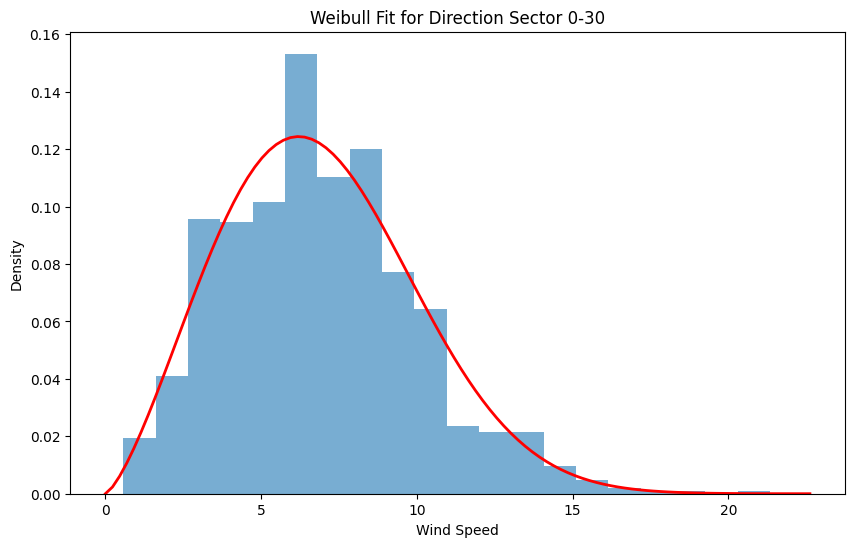

In [0]:
#calc freqs and weibull params for 30 degree direction buckets
weibull_params = {}
direction_bins = np.arange(0, 361, 30)
# For each directional sector
for i in range(len(direction_bins)-1):
    # Get wind speeds for this direction sector
    mask = (generation_weather_df['wind_80m_dir'] >= direction_bins[i]) & (generation_weather_df['wind_80m_dir'] < direction_bins[i+1])
    sector_speeds = generation_weather_df.loc[mask, 'wind_80m_mps']
    
    shape, loc, scale = stats.weibull_min.fit(sector_speeds, floc=0)  # force location parameter to 0
    
    # Store parameters
    sector_name = f'{direction_bins[i]}-{direction_bins[i+1]}'
    weibull_params[sector_name] = {
        'A': scale,
        'k': shape,
        'n_samples': len(sector_speeds),
        'f': len(sector_speeds)/len(generation_weather_df)
    }

params_df = pd.DataFrame(weibull_params).T
print(params_df)

sector = list(weibull_params.keys())[0]  # first sector
speeds = np.linspace(0, generation_weather_df['wind_80m_mps'].max(), 100)
fitted_dist = stats.weibull_min(
    weibull_params[sector]['k'], 
    loc=0, 
    scale=weibull_params[sector]['A']
)

plt.figure(figsize=(10,6))
plt.hist(generation_weather_df.loc[generation_weather_df['wind_80m_dir'].between(float(sector.split('-')[0]), 
                                           float(sector.split('-')[1])), 
                'wind_80m_mps'], 
         density=True, bins=20, alpha=0.6)
plt.plot(speeds, fitted_dist.pdf(speeds), 'r-', lw=2)
plt.title(f'Weibull Fit for Direction Sector {sector}')
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.show()


In [0]:
#build a uniform weibull pywake site with twelve 30 degree distributions

f = params_df['f'].values
A = params_df['A'].values
k = params_df['k'].values
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = .33

#specifying the necessary parameters for the UniformWeibullSite object
weibull_site = UniformWeibullSite(p_wd = f,                         # sector frequencies
                          a = A,     # Weibull scale parameter
                          k = k,     # Weibull shape parameter
                          ti = 0.33  # turbulence intensity, optional
                         )

# Site with constant wind speed, sector frequency, constant turbulence intensity and power shear
#its not clear to me how these static site parameters interact with the time series values
uniform_site = XRSite(
    ds=xr.Dataset(data_vars={'WS': 7.4, 'P': ('wd', f), 'TI': ti},
                  coords={'wd': wd}),
    shear=PowerShear(h_ref=80, alpha=.1), initial_position = coordinate_pairs)




In [0]:
#i dont have a full understanding of the components of these turbulence/propogation/wake engineering models but I tried several of the built in wake effect packages and I found two that appeared different enough to demonstrate the magnitude of the impact this choice has on the simulation results
#xr.set_options(display_expand_data=False)
#site = site
x, y = uniform_site.initial_position.T
windTurbines = my_wt

#wf_model = Ott_Nielsen_2014_Blockage(site, windTurbines)
wf_model = Zong_PorteAgel_2020(weibull_site, windTurbines)
wf_model2 = Bastankhah_PorteAgel_2014(weibull_site, windTurbines, .0324555)

print(wf_model)
print(wf_model2)

Zong_PorteAgel_2020(PropagateDownwind, ZongGaussianDeficit-wake, WeightedSum-superposition, CrespoHernandez-turbulence)
Bastankhah_PorteAgel_2014(PropagateDownwind, BastankhahGaussianDeficit-wake, LinearSum-superposition)


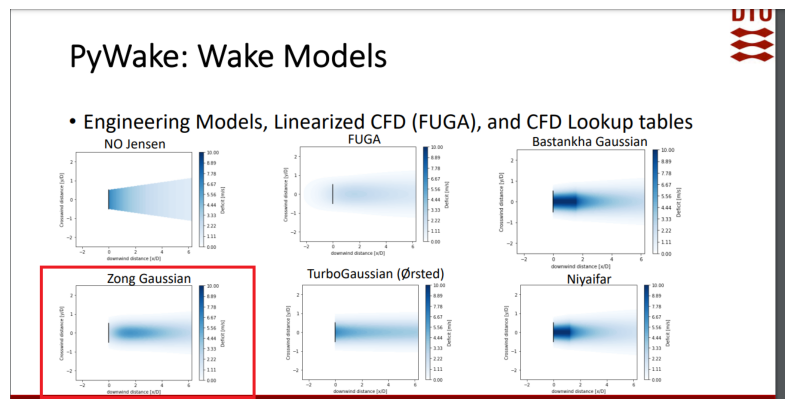

In [0]:
#you can see a viz of the wake models below. Zong looked pretty good to me and is more recent (2020), bastankha gaussian looks crude, is older (2014), and is missing turbulence
from PIL import Image
import matplotlib.pyplot as plt

# Load and display the image
image_path = "/dbfs/FileStore/tmp/wake_models.png"
img = Image.open(image_path)

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [0]:
#simulate all directions and all wind speeds for zong
sim_res = wf_model(turbine_locs['x'].values, turbine_locs['y'].values,     # wind turbine positions
                   h=turbine_locs['hub height'].values,   # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0,   # Wind turbine types
                   wd=generation_weather_df['wind_80m_dir'].values[:50],  # Wind direction
                   ws=generation_weather_df['wind_80m_mps'].values[:50],  # Wind speed
                  )
sim_res2 = wf_model2(turbine_locs['x'].values, turbine_locs['y'].values,     # wind turbine positions
                   h=turbine_locs['hub height'].values,   # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0,   # Wind turbine types
                   wd=generation_weather_df['wind_80m_dir'].values[:50],  # Wind direction
                   ws=generation_weather_df['wind_80m_mps'].values[:50],  # Wind speed
                  )

Text(0.5, 0, 'x [m]')

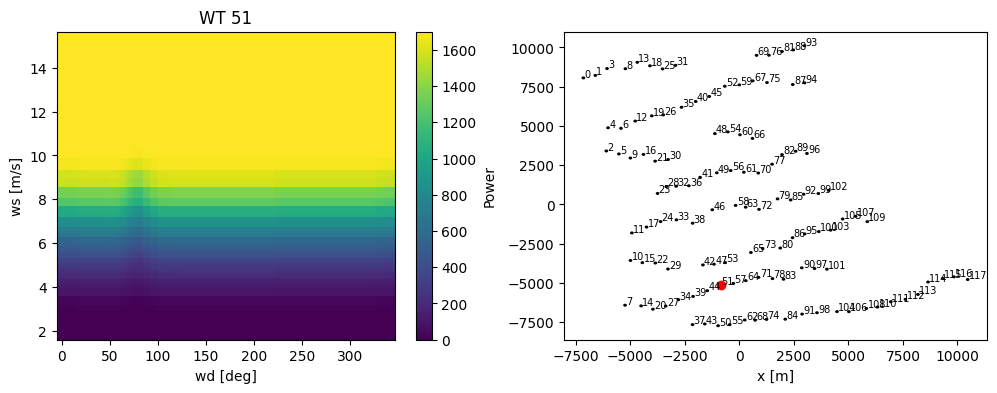

In [0]:
#ws/wd power results for a single turbine at the facility with zong
#I'm not sure I buy this plot, it looks to me like power generation is pretty consistent regardless of wind direction and that doesn't seem right.
#there is a very slight penalty @ ~70 degrees which looks right
ax1, ax2 = plt.subplots(1,2, figsize=(12,4))[1]
sim_res.Power.sel(wt=51).T.sortby('ws','wd').plot(ax=ax1)
ax1.set_xlabel('wd [deg]')
ax1.set_ylabel('ws [m/s]')
ax1.set_title('WT 51')
windTurbines.plot(x,y, ax=ax2)
ax2.plot(x[51],y[51],'or')
ax2.set_xlabel('x [m]')

Text(0.5, 0, 'x [m]')

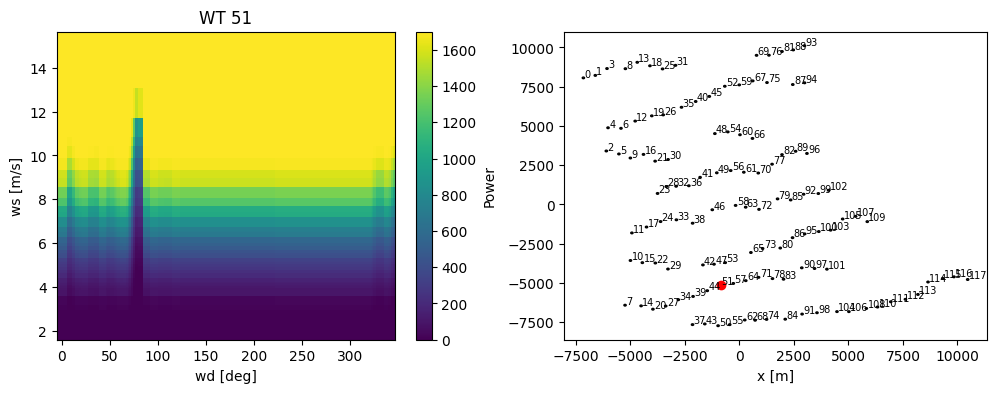

In [0]:
#ws/wd power results for a single turbine at the facility with bastankhah
#This looks much better, we see real power gen penalties around 70 degrees and some smaller effects in the 0-70 and 330+ ranges
ax1, ax2 = plt.subplots(1,2, figsize=(12,4))[1]
sim_res2.Power.sel(wt=51).T.sortby('ws','wd').plot(ax=ax1)
ax1.set_xlabel('wd [deg]')
ax1.set_ylabel('ws [m/s]')
ax1.set_title('WT 51')
windTurbines.plot(x,y, ax=ax2)
ax2.plot(x[51],y[51],'or')
ax2.set_xlabel('x [m]')

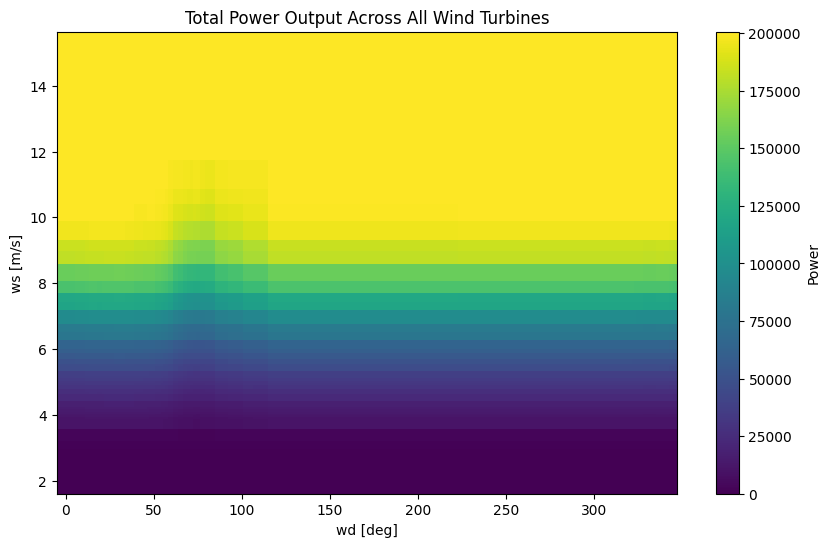

In [0]:
#given the uniform weibull site, the defined turbine characteristics and the farm layout (but not the time series data)
#whats the optimal wind direction for the farm
#you can see the power penalty around ~70-110 degrees is a feature not just of turbine 51 but of the farm layout in aggregate, though otherwise the power output is pretty consistent
import matplotlib.pyplot as plt

# Sum the power output across all wind turbines
total_power = sim_res2.Power.sum(dim='wt')

# Create a single plot for the aggregated power output
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the aggregated power data
total_power.T.sortby(['ws', 'wd']).plot(ax=ax)

# Customize the plot
ax.set_xlabel('wd [deg]')
ax.set_ylabel('ws [m/s]')
ax.set_title('Total Power Output Across All Wind Turbines')

plt.show()


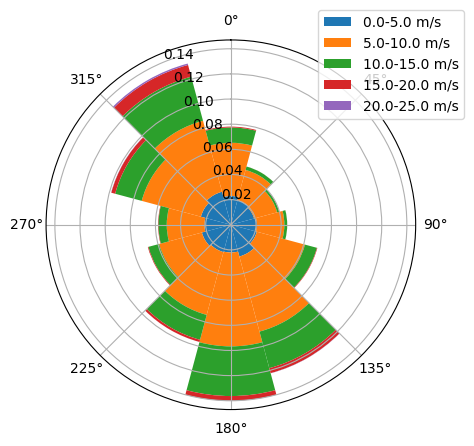

In [0]:

#wind rose looks right from visual inspection / comparison with the farm layout above, i would expect wind parallel with the ridges to produce wake losses
#The layout is good then, the wind rarely comes from the direction where the layout has a power output penalty from wake losses

_ = weibull_site.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25])

In [0]:
#we dont have hourly wind speed stdev so calculating turbulence intensity on a daily level using daily avg wind speed and stdev
#the avg ti calculated here flows back to the static ti definition for the site
#yeah this is ugly code but it works
generation_weather_df.index = pd.to_datetime(generation_weather_df.index)
daily_stdev = generation_weather_df['wind_80m_mps'].resample('D').std()
daily_avg = generation_weather_df['wind_80m_mps'].resample('D').mean()
generation_weather_df['date'] = generation_weather_df.index.floor('D')

daily_avg_df = daily_avg.to_frame('wind_80m_mps_daily_avg')
daily_stdev_df = daily_stdev.to_frame('wind_80m_mps_daily_stdev')

generation_weather_df2 = generation_weather_df.merge(
    daily_avg_df, 
    left_on='date', 
    right_index=True, 
    how='left'
)
generation_weather_df2 = generation_weather_df2.merge(
    daily_stdev_df, 
    left_on='date', 
    right_index=True, 
    how='left'
)
generation_weather_df2 = generation_weather_df2.drop('date', axis=1)
generation_weather_df2['ti']=np.minimum(generation_weather_df2['wind_80m_mps_daily_stdev']/generation_weather_df2['wind_80m_mps_daily_avg'],.5)
display(generation_weather_df2.head(10))

generation_mw,temp_2m,dew_2m,mslp,wind_10m_mps,wind_10m_dir,wind_100m_mps,wind_100m_dir,custom_height,wind_80m_mps,wind_80m_dir,ghi,wind_alpha,wind_80m_mps_daily_avg,wind_80m_mps_daily_stdev,ti
68.6064803756134,3.68,-4.03,1007,3.97,38,10.58,43,80,9.62,43,0.0,0.4256951609360519,5.638823529411765,1.8465064390388044,0.32746306555038257
117.56081520066,2.29,-5.61,1007,4.12,43,9.73,47,80,8.95,47,0.0,0.3732156242352173,5.638823529411765,1.8465064390388044,0.32746306555038257
106.10359110148956,0.08,-7.18,1008,4.09,44,8.54,49,80,7.95,48,0.0,0.3197345626816633,5.638823529411765,1.8465064390388044,0.32746306555038257
87.23409209354531,-1.34,-6.55,1008,3.34,5,7.04,22,80,6.55,20,0.0,0.3238261923305477,5.638823529411765,1.8465064390388044,0.32746306555038257
49.02822940078574,-1.97,-6.62,1009,3.54,348,6.92,15,80,6.48,12,0.0,0.29110283243097,5.638823529411765,1.8465064390388044,0.32746306555038257
27.02396596724417,-0.82,-5.49,1009,3.76,349,6.96,13,80,6.56,10,0.0,0.2674213946829011,5.638823529411765,1.8465064390388044,0.32746306555038257
20.58623543399338,-0.2,-4.54,1009,3.36,352,6.14,19,80,5.79,15,0.0,0.2618290937513236,5.638823529411765,1.8465064390388044,0.32746306555038257
11.26413215981543,-0.6,-4.21,1010,2.53,334,4.53,29,80,4.28,22,0.0,0.252977680837014,5.638823529411765,1.8465064390388044,0.32746306555038257
11.38662900942823,0.43,-3.23,1011,1.59,316,3.37,41,80,3.13,33,20.0,0.3262327765508871,5.638823529411765,1.8465064390388044,0.32746306555038257
14.3024270284508,0.01,-2.98,1012,2.12,32,4.37,58,80,4.07,55,141.0,0.3141455760416704,5.638823529411765,1.8465064390388044,0.32746306555038257


In [0]:
#check that ti distribution is reasonable
generation_weather_df2.describe()

,generation_mw,temp_2m,dew_2m,mslp,wind_10m_mps,wind_10m_dir,wind_100m_mps,wind_100m_dir,custom_height,wind_80m_mps,wind_80m_dir,ghi,wind_alpha,wind_80m_mps_daily_avg,wind_80m_mps_daily_stdev,ti
count,12399.000000,12399.000000,12399.000000,12399.000000,12399.000000,12399.000000,12399.000000,12399.000000,12399.0,12399.000000,12399.000000,12399.000000,12399.000000,12399.000000,12399.000000,12399.000000
mean,87.989479,8.989319,-1.396534,1014.555367,4.520813,202.802000,7.811236,199.804500,80.0,7.382331,200.661828,200.593435,0.235911,7.382331,2.410015,0.338477
std,70.010989,10.659041,9.398193,8.384040,2.359479,99.085084,3.727644,101.273726,0.0,3.503253,100.948473,284.855816,0.132083,2.454025,0.845479,0.108047
min,0.000000,-24.030000,-31.830000,986.000000,0.440000,0.000000,0.520000,0.000000,80.0,0.530000,0.000000,0.000000,-0.202544,2.656250,0.675072,0.055588
25%,21.582630,0.685000,-8.455000,1009.000000,2.830000,142.000000,5.040000,136.500000,80.0,4.790000,138.000000,0.000000,0.099493,5.670833,1.829873,0.258987
50%,74.734328,9.030000,-3.100000,1014.000000,3.980000,203.000000,7.510000,198.000000,80.0,7.060000,199.000000,0.000000,0.248178,6.877917,2.277577,0.340116
75%,160.550688,16.985000,6.895000,1020.000000,5.700000,289.000000,10.130000,291.000000,80.0,9.500000,292.000000,377.000000,0.353875,8.597083,2.893033,0.425252
max,199.454067,35.390000,20.380000,1041.000000,15.690000,359.000000,23.700000,359.000000,80.0,22.620000,360.000000,1073.000000,0.634853,18.511667,5.738711,0.500000


In [0]:
#produce the array vars for a time-series simulation
ws = np.array(generation_weather_df2['wind_80m_mps'])
wd = np.array(generation_weather_df2['wind_80m_dir'])
ti = np.array(generation_weather_df2['ti'])
time_stamp = generation_weather_df2.index.values

In [0]:
#run the time series simulation of the wind farm
#zong:
sim_res_time = wf_model(x, y, # wind turbine positions
                        wd=wd, # Wind direction time series
                        ws=ws, # Wind speed time series
                        time=time_stamp, # time stamps
                        TI=ti # turbulence intensity time series
                  )
#bastankha
sim_res_time2 = wf_model2(x, y, # wind turbine positions
                        wd=wd, # Wind direction time series
                        ws=ws, # Wind speed time series
                        time=time_stamp, # time stamps
                        TI=ti # turbulence intensity time series
                  )

In [0]:
#not able to get the wake map working :(
# from py_wake import HorizontalGrid

# for grid in [ # custom resolution and extend
#              HorizontalGrid(x = np.arange(-10000,10000,100),
#                             y = np.arange(-10000,10000,100))               # custom x and y
#             ]:
#     plt.figure()
#     sim_res.flow_map(grid=grid, wd=43, ws=[9.62]).plot_wake_map()
#     plt.xlabel('x [m]')
#     plt.ylabel('y [m]')

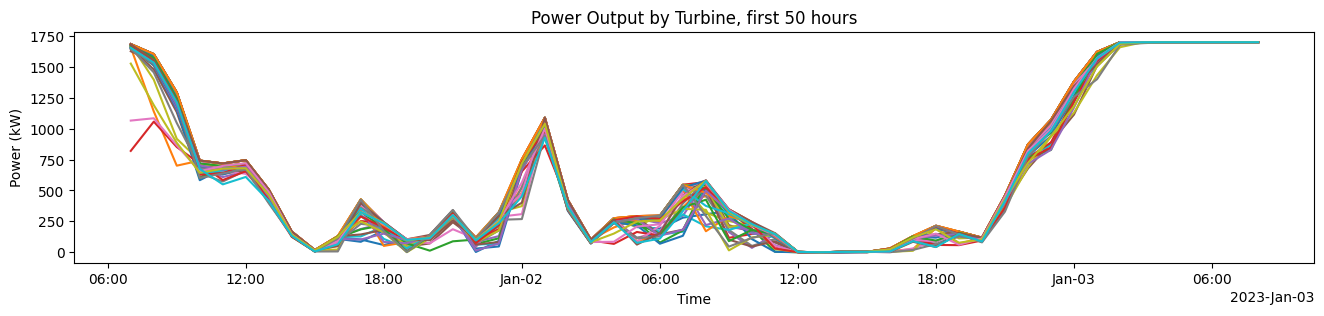

In [0]:
#turbine level simulated power output for 40 turbines over the first 50 hours w/ bastankha, which seems very harsh on this farm layout, lots of wake effects disrupting power output
fig, ax = plt.subplots(figsize=(16,3))
for i in range(40):  # for turbines 0-3
    sim_res_time2.Power.sel(wt=i)[:50].plot(ax=ax, label=f'Turbine {i}')

#plt.legend()
plt.title('Power Output by Turbine, first 50 hours')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.show()


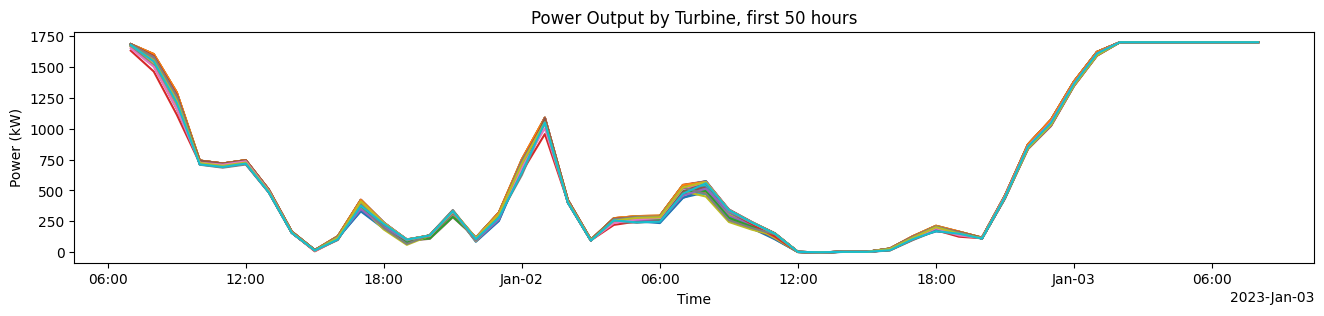

In [0]:
#turbine level simulated power output for the first 50 hours w/ zong for 40 turbines
#spread is much tighter here, little variance in how individual turbines are performing
fig, ax = plt.subplots(figsize=(16,3))
for i in range(40):  # for turbines 0-3
    sim_res_time.Power.sel(wt=i)[:50].plot(ax=ax, label=f'Turbine {i}')

#plt.legend()
plt.title('Power Output by Turbine, first 50 hours')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.show()


In [0]:
ad = (generation_weather_df2.generation_mw * 1000).reset_index()
sim_gen_df = sim_res_time.Power.sum(dim='wt').to_dataframe().reset_index()


In [0]:
### comparing zong and bast wake models against actuals
#there are some time shifting effects I dont fully understand here like 1/5/2023 9:00AM. Wind speed peaks around 4AM and by 11AM it has slumped to cutoff levels yet the facilities output at 9:00 AM is 176 MW, thats a 88% capacity factor with wind speeds of 4.5 m/s. Power curve has the facility at ~36kW at that speed. I'd love to know whats happening here because the simulation doesn't catch it.

#I see a lot of periods where the simulation is maxing out the capacity factor of the facility and the real numbers are wobbling below that. These are probably local orography effects or complex wake effects that neither model is capturing

# Sum power across all turbines (dimension 'wt') for each timestep
bast_simulated_power = sim_res_time2.Power.sum(dim='wt').to_pandas()
zong_simulated_power = sim_res_time.Power.sum(dim='wt').to_pandas()
actual_power = (generation_weather_df2.generation_mw * 1000)

# Create a DataFrame for Plotly
df = pd.DataFrame({
    'Time': bast_simulated_power.index,
    'Bast Simulated Power': bast_simulated_power.values,
    'Zong Simulated Power': zong_simulated_power.values,
    'Total Actual Power': actual_power.values
})

# Plot the total using Plotly Express
fig = px.line(df, x='Time', y=['Bast Simulated Power', 'Zong Simulated Power', 'Total Actual Power'], 
              labels={'value': 'Total Power (kW)', 'variable': 'Legend'},
              title='Total Wind Farm Power Output')
fig.show()

/databricks/python/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



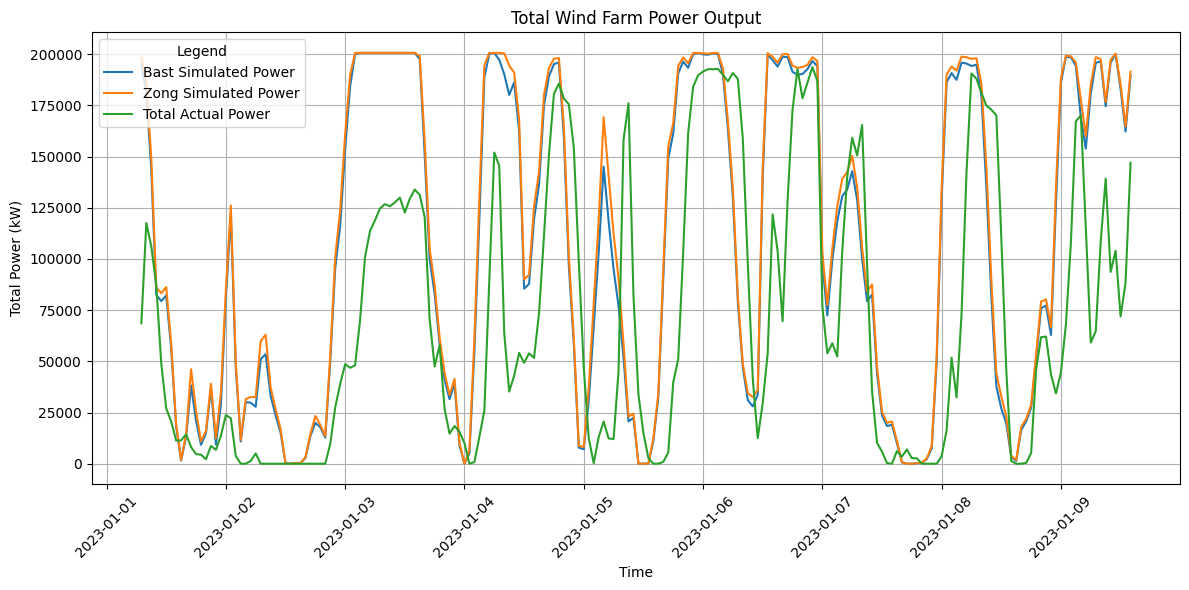

In [0]:
###apparently plotly express charts dont travel well so here is a non-interactive version of the plot (time truncated for sanity)
df = pd.DataFrame({
    'Time': bast_simulated_power.index[:200],
    'Bast Simulated Power': bast_simulated_power.values[:200],
    'Zong Simulated Power': zong_simulated_power.values[:200],
    'Total Actual Power': actual_power.values[:200]
})

plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Bast Simulated Power'], label='Bast Simulated Power', linestyle='-', marker='')
plt.plot(df['Time'], df['Zong Simulated Power'], label='Zong Simulated Power', linestyle='-', marker='')
plt.plot(df['Time'], df['Total Actual Power'], label='Total Actual Power', linestyle='-', marker='')

plt.title('Total Wind Farm Power Output')
plt.xlabel('Time')
plt.ylabel('Total Power (kW)')
plt.legend(title='Legend')
plt.grid(True)
plt.xticks(rotation=45) 

# Show the plot
plt.tight_layout()
plt.show()


In [0]:
#first lets check a unit error measurement, RMSE, for zong and bastankha
simulated_power_df = pd.DataFrame(zong_simulated_power)
simulated_power_df.index = simulated_power_df.index.tz_localize('UTC')
actual_power_df = pd.DataFrame(actual_power)
# Concatenate the DataFrames on the timestamp
z_joined_df = pd.concat([simulated_power_df, actual_power_df], axis=1)
# Calculate RMSE
z_joined_df['squared_error'] = (z_joined_df['Power'] - z_joined_df['generation_mw']) ** 2
zong_rmse = np.sqrt(z_joined_df['squared_error'].mean())
print('zong_rmse: ',zong_rmse)


zong_rmse:  56180.7203713123


In [0]:
#bast in the end outperforms zong, though both methods here have pretty high error rates.
#RMSE is a unit error measurement so thats 54MW error.
#Frankly I think the plots look better than that RMSE suggests
simulated_power_df = pd.DataFrame(bast_simulated_power)
simulated_power_df.index = simulated_power_df.index.tz_localize('UTC')
actual_power_df = pd.DataFrame(actual_power)
# Concatenate the DataFrames on the timestamp
bast_joined_df = pd.concat([simulated_power_df, actual_power_df], axis=1)
# Calculate RMSE
bast_joined_df['squared_error'] = (bast_joined_df['Power'] - bast_joined_df['generation_mw']) ** 2
bast_rmse = np.sqrt(bast_joined_df['squared_error'].mean())
print('bastankha rmse: ', bast_rmse)


bastankha rmse:  54364.33787812542


<AxesSubplot:>

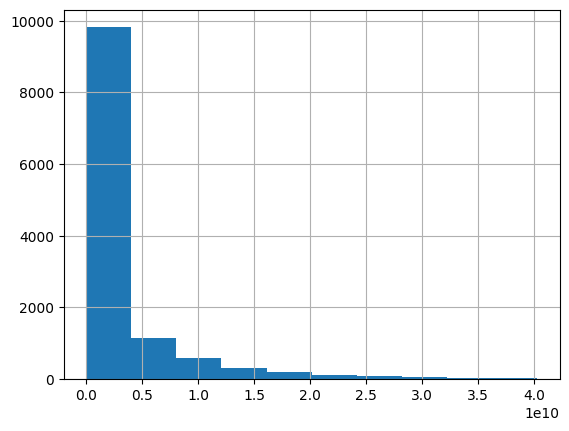

In [0]:
#lets look at the distribution of squared error for bastankha
#bit of a long / fat tail there, those are probably curtailment or maintenance events
#but it looks like the error is mostly from consistently overstating the peaks
simulated_power_df = pd.DataFrame(bast_simulated_power)
simulated_power_df.index = simulated_power_df.index.tz_localize('UTC')
actual_power_df = pd.DataFrame(actual_power)
# Concatenate the DataFrames on the timestamp
bast_joined_df = pd.concat([simulated_power_df, actual_power_df], axis=1)
# Calculate RMSE
bast_joined_df['squared_error'] = (bast_joined_df['Power'] - bast_joined_df['generation_mw']) ** 2
display(bast_joined_df['squared_error'].hist())

In [0]:
#real quick I want to try to chop curtailment events and see how it impacts the RMSE. obviously no real way to detect partial curtailment (except deviation from the sim) so I'll just apply some low threshold to catch curtailment events that hit essentially all the turbines at the facility, i.e. actual CF < 10% and modeled CF > 50%
#basically no impact so the the conclusion that the error is not driven by sparse high error events holds, this is a daily operations simulation issue
excluded_df = bast_joined_df[~((bast_joined_df['generation_mw'] < 20) & (bast_joined_df['Power'] > 100))]
bast_rmse_uncurtailed = np.sqrt(excluded_df['squared_error'].mean())
print('bastankha rmse (w/ simple curtailment filter): ', bast_rmse_uncurtailed)

bastankha rmse (w/ simple curtailment filter):  54312.872830135246


In [0]:
#now lets check kling-gupta efficiency, a metric we borrow from hydrology to evaluate the performance models. KGE captures correlation, bias, and variance. Closer to 1 is better
#this is sloppy but I was running out of time
#again the simpler model (bastankha) outperforms the newer model with turbulence.
#Those aren't bad KGEs, we are usually happy with ~.7/1.3 the first time we swing at a model in a new domain

simulated = z_joined_df['Power']
actual = z_joined_df['generation_mw']

# Calculate components of KGE
r = np.corrcoef(simulated, actual)[0, 1]  # Pearson correlation coefficient
beta = simulated.mean() / actual.mean()  # Bias ratio
gamma = (simulated.std() / simulated.mean()) / (actual.std() / actual.mean())  # Variability ratio

# Calculate KGE
z_kge = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)

simulated = bast_joined_df['Power']
actual = bast_joined_df['generation_mw']

# Calculate components of KGE
r = np.corrcoef(simulated, actual)[0, 1]  # Pearson correlation coefficient
beta = simulated.mean() / actual.mean()  # Bias ratio
gamma = (simulated.std() / simulated.mean()) / (actual.std() / actual.mean())  # Variability ratio

# Calculate KGE
b_kge = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)

print('Zong Kling-Gupta Efficiency (KGE): ', z_kge)
print('Bastankha Kling-Gupta Efficiency (KGE): ', b_kge)


Zong Kling-Gupta Efficiency (KGE):  0.6496338882489061
Bastankha Kling-Gupta Efficiency (KGE):  0.6814541454761694


In [0]:
##conclusions:
#we aren't capturing some effect that keeps actual performance below the simulated peak performance. the simulated farm is hitting max CF pretty regularly and the actuals are not.
#is this sub grid orography/terrain?
#is it air density or other weather variables we have failed to consider here?
#i worry that the poor(er) performance of zong means it was not configured correctly
#hope this meets your expectations, fun exercise.


In [0]:
#Some QA around the morning of 1/5/2023 and the unusual wind gen / wind speed ratios there
import plotly.express as px

fig = px.line(generation_weather_df2, x=generation_weather_df2.index, y=['wind_80m_mps', 'generation_mw'], title='Wind Speed and Power Generation Over Time')
fig.update_layout(
    yaxis=dict(title='Wind Speed (m/s)'),
    yaxis2=dict(title='Power Generation (MW)', overlaying='y', side='right'),
    legend=dict(x=0.1, y=1.1, orientation='h')
)
fig.update_traces(yaxis='y2', selector=dict(name='generation_mw'))
fig.show()

/databricks/python/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

